# Phân lớp

## Import thư viện

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
from PIL import Image
import os
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report 
import seaborn as sns 
import matplotlib.pyplot as plt 

## Xây dựng mô hình Resnet50

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class IdentityBlock(nn.Module):
    def __init__(self, in_channels, filters):
        super(IdentityBlock, self).__init__()
        F1, F2, F3 = filters

        self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(F1)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(F1, F2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(F2)

        self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(F3)
    

    def forward(self, X):
        shortcut = X

        X = self.conv1(X)
        X = self.bn1(X)
        X = self.relu(X)

        X = self.conv2(X)
        X = self.bn2(X)
        X = self.relu(X)

        X = self.conv3(X)
        X = self.bn3(X)

        X += shortcut
        X = self.relu(X)
        return X

class ConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, filters, s=2):
        super(ConvolutionalBlock, self).__init__()
        F1, F2, F3 = filters

        self.conv1 = nn.Conv2d(in_channels, F1, kernel_size=1, stride=s, padding=0)
        self.bn1 = nn.BatchNorm2d(F1)
        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(F1, F2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(F2)

        self.conv3 = nn.Conv2d(F2, F3, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(F3)

        self.conv_shortcut = nn.Conv2d(in_channels, F3, kernel_size=1, stride=s, padding=0)  # in_channels -> F3
        self.bn_shortcut = nn.BatchNorm2d(F3)

    def forward(self, X):
        shortcut = X

        X = self.conv1(X)
        X = self.bn1(X)
        X = self.relu(X)

        X = self.conv2(X)
        X = self.bn2(X)
        X = self.relu(X)

        X = self.conv3(X)
        X = self.bn3(X)

        shortcut = self.conv_shortcut(shortcut)
        shortcut = self.bn_shortcut(shortcut)

        X += shortcut
        X = self.relu(X)

        return X

class ResNet50(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), num_classes=10):
        super(ResNet50, self).__init__()

        self.zero_pad = nn.ZeroPad2d(3)
        self.conv1 = nn.Conv2d(input_shape[0], 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stage2 = nn.Sequential(
            ConvolutionalBlock(64, [64, 64, 256], s=1),
            IdentityBlock(256, [64, 64, 256]),
            IdentityBlock(256, [64, 64, 256])
        )

        self.stage3 = nn.Sequential(
            ConvolutionalBlock(256, [128, 128, 512], s=2),
            IdentityBlock(512, [128, 128, 512]),
            IdentityBlock(512, [128, 128, 512]),
            IdentityBlock(512, [128, 128, 512])
        )

        self.stage4 = nn.Sequential(
            ConvolutionalBlock(512, [256, 256, 1024], s=2),
            *[IdentityBlock(1024, [256, 256, 1024]) for _ in range(5)]
        )

        self.stage5 = nn.Sequential(
            ConvolutionalBlock(1024, [512, 512, 2048], s=2),
            IdentityBlock(2048, [512, 512, 2048]),
            IdentityBlock(2048, [512, 512, 2048])
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # GlobalAvgPool2D
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, X):
        x = self.zero_pad(X)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)        

        x = self.stage2(x)
        
        x = self.stage3(x)
        
        x = self.stage4(x)
        
        x = self.stage5(x)
        
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)  
        x = self.fc(x)

        return x

# Kiểm tra mô hình ResNet50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = ResNet50(input_shape=(3, 224, 224)).to(device)
x = torch.randn(1, 3, 224, 224).to(device)  # Batch size = 1, RGB image 224x224
output = resnet50(x)

print("Output shape:", output.shape)

# In thông số mô hình
summary(resnet50, input_size=(3, 224, 224), device=str(device))

Output shape: torch.Size([1, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 230, 230]               0
            Conv2d-2         [-1, 64, 115, 115]           9,472
       BatchNorm2d-3         [-1, 64, 115, 115]             128
              ReLU-4         [-1, 64, 115, 115]               0
         MaxPool2d-5           [-1, 64, 58, 58]               0
            Conv2d-6           [-1, 64, 58, 58]           4,160
       BatchNorm2d-7           [-1, 64, 58, 58]             128
              ReLU-8           [-1, 64, 58, 58]               0
            Conv2d-9           [-1, 64, 58, 58]          36,928
      BatchNorm2d-10           [-1, 64, 58, 58]             128
             ReLU-11           [-1, 64, 58, 58]               0
           Conv2d-12          [-1, 256, 58, 58]          16,640
      BatchNorm2d-13          [-1, 256, 58, 58]             512
     

## Xây dựng Dataset và DataLoader

In [5]:
class ChessPiecesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.samples = []
        for target_class in self.classes:
            class_dir = os.path.join(self.root_dir, target_class)
            for root, _, fnames in sorted(os.walk(class_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    item = path, self.class_to_idx[target_class]
                    self.samples.append(item)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        sample = Image.open(path).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [7]:
# Data augmentation và transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [9]:
# Create datasets
train_dataset = ChessPiecesDataset(root_dir='Downloads/chess_pieces_classification-main/ChessPieces_Dataset/train', transform=train_transforms)
val_dataset = ChessPiecesDataset(root_dir='Downloads/chess_pieces_classification-main/ChessPieces_Dataset/val', transform=val_test_transforms)
test_dataset = ChessPiecesDataset(root_dir='Downloads/chess_pieces_classification-main/ChessPieces_Dataset/test', transform=val_test_transforms)


# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
import torch

if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected. Running on CPU.")

GPU is available: NVIDIA GeForce RTX 2060


## Chọn và xây dựng mô hình Resnet50

In [13]:
# Sử dụng ResNet đã tạo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(input_shape=(3, 224, 224), num_classes=6).to(device)
model = model.to(device)
print(device)

cuda


## Huấn luyện mô hình

In [15]:
# Định nghĩa hàm mất mát và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  

# Huấn luyện
num_epochs = 30  
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step()  

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

  
    model.eval()  
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): 
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_loss = running_loss / len(val_dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)


    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/30, Train Loss: 1.7533, Train Acc: 26.20%, Val Loss: 1.5467, Val Acc: 37.64%
Epoch 2/30, Train Loss: 1.4209, Train Acc: 43.79%, Val Loss: 1.2997, Val Acc: 50.42%
Epoch 3/30, Train Loss: 1.1851, Train Acc: 54.07%, Val Loss: 1.2043, Val Acc: 52.22%
Epoch 4/30, Train Loss: 1.0259, Train Acc: 61.25%, Val Loss: 1.0527, Val Acc: 63.61%
Epoch 5/30, Train Loss: 0.8859, Train Acc: 66.44%, Val Loss: 0.9452, Val Acc: 65.14%
Epoch 6/30, Train Loss: 0.7580, Train Acc: 71.86%, Val Loss: 1.0995, Val Acc: 61.25%
Epoch 7/30, Train Loss: 0.6483, Train Acc: 75.75%, Val Loss: 0.8173, Val Acc: 72.36%
Epoch 8/30, Train Loss: 0.5818, Train Acc: 78.86%, Val Loss: 0.8784, Val Acc: 72.78%
Epoch 9/30, Train Loss: 0.5047, Train Acc: 81.34%, Val Loss: 0.9323, Val Acc: 73.61%
Epoch 10/30, Train Loss: 0.4513, Train Acc: 83.21%, Val Loss: 0.7965, Val Acc: 74.44%
Epoch 11/30, Train Loss: 0.4041, Train Acc: 85.48%, Val Loss: 0.8488, Val Acc: 74.31%
Epoch 12/30, Train Loss: 0.3521, Train Acc: 87.50%, Val Loss: 0

## Đánh giá mô hình trên tập test

In [25]:
model.eval()  
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy()) 


print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 84.17%


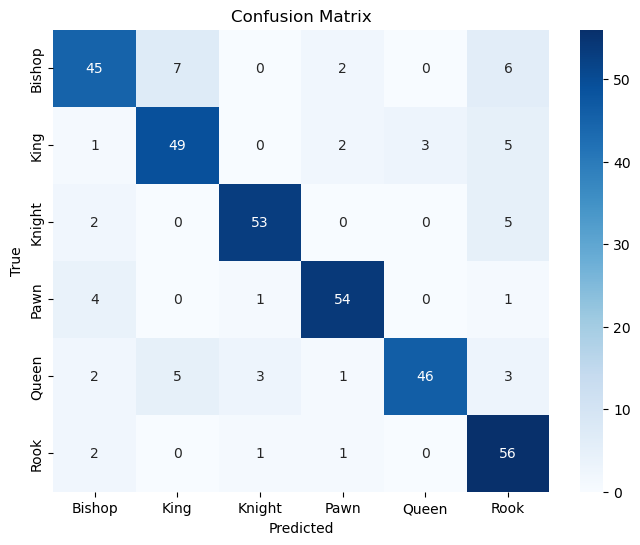

In [27]:
# Confusion matrix 
cm = confusion_matrix(all_labels, all_predictions)
class_names = test_dataset.classes 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Classification report
print(classification_report(all_labels, all_predictions, target_names=class_names))

              precision    recall  f1-score   support

      Bishop       0.80      0.75      0.78        60
        King       0.80      0.82      0.81        60
      Knight       0.91      0.88      0.90        60
        Pawn       0.90      0.90      0.90        60
       Queen       0.94      0.77      0.84        60
        Rook       0.74      0.93      0.82        60

    accuracy                           0.84       360
   macro avg       0.85      0.84      0.84       360
weighted avg       0.85      0.84      0.84       360



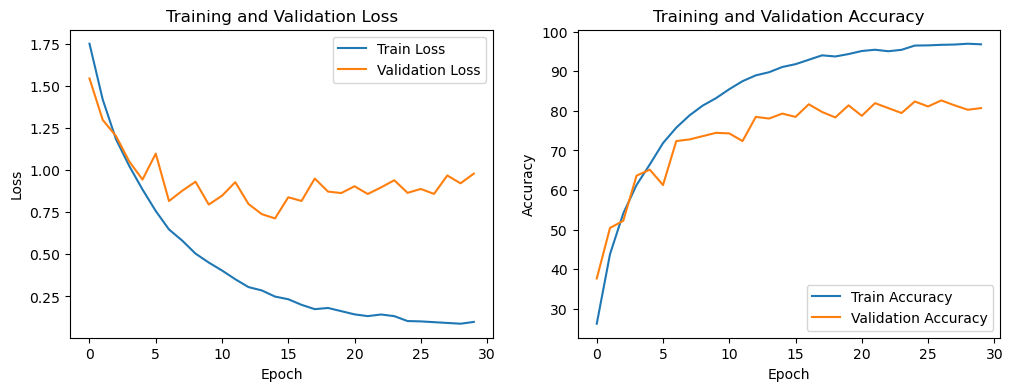

In [31]:
# Vẽ loss và accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

## Lưu mô hình

In [67]:
torch.save(model.state_dict(), "chess_classifier_resnet_custom.pth")
print("Lưu mô hình thành công!")

Lưu mô hình thành công!


## Load mô hình và dự đoán

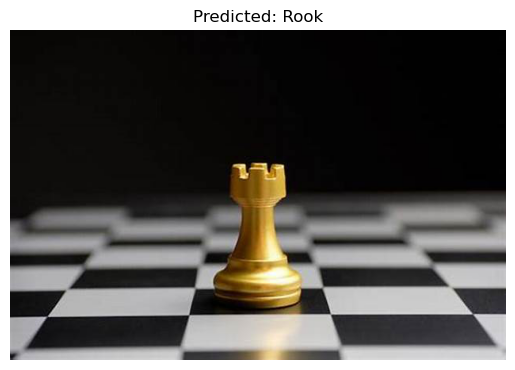

In [69]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import requests  
from io import BytesIO  
import matplotlib.pyplot as plt 


# Load mô hình 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load toàn bộ model
model.load_state_dict(torch.load('chess_classifier_resnet_custom.pth', map_location=device, weights_only=True), strict=True) 
model = model.to(device)
model.eval()



def predict_chess_piece(image_path, model):
    try:
        # Tải ảnh từ URL nếu image_path là URL, nếu không thì mở từ đường dẫn local
        if image_path.startswith('http'):
            response = requests.get(image_path, stream=True)
            response.raise_for_status()  # Kiểm tra lỗi HTTP
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = Image.open(image_path).convert('RGB')

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        img_tensor = transform(img)
        img_tensor = img_tensor.unsqueeze(0)  
        img_tensor = img_tensor.to(device)

        with torch.no_grad():
            output = model(img_tensor)
            _, predicted = torch.max(output.data, 1)
            class_names = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
            predicted_class_name = class_names[predicted.item()]

        # Hiển thị ảnh
        plt.imshow(img)
        plt.title(f'Predicted: {predicted_class_name}')
        plt.axis('off')  
        plt.show()

        return predicted_class_name
    except requests.exceptions.RequestException as e:
        print(f"Lỗi khi tải ảnh từ URL: {e}")
        return None
    except FileNotFoundError:
        print(f"Không tìm thấy file ảnh tại đường dẫn: {image_path}")
        return None
    except Exception as e:
        print(f"Lỗi: {e}")
        return None




# Lấy URL ảnh từ Google 
image_url = "https://th.bing.com/th/id/OIP.WFJWXStgROcAoCjo4h-O_QHaE7?w=626&h=417&rs=1&pid=ImgDetMain"  

# Dự đoán và hiển thị
predicted_piece = predict_chess_piece(image_url, model)

## Fine-tuning model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import os
import time
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# Thiết lập device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Data augmentation và transforms (giữ nguyên như khi train)
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
# Tạo datasets 
train_dataset = datasets.ImageFolder(root='Downloads/chess_pieces_classification-main/ChessPieces_Dataset/train', transform=train_transforms)
val_dataset = datasets.ImageFolder(root='Downloads/chess_pieces_classification-main/ChessPieces_Dataset/val', transform=val_transforms)

# Tạo DataLoaders 
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

In [15]:
#Sử dụng mô hình Resnet50 đã tạo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(input_shape=(3, 224, 224), num_classes=6).to(device)
model = model.to(device)

# Load state_dict từ file đã lưu
model.load_state_dict(torch.load('chess_classifier_resnet_custom.pth', map_location=device, weights_only=True))
model = model.to(device)

## Fine-tune toàn bộ mô hình với learning rate thấp

In [17]:
# Cho phép fine-tune toàn bộ mô hình
for param in model.parameters():
    param.requires_grad = True

# Sử dụng learning rate nhỏ
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # lr nhỏ để tránh làm mất trọng số cũ

# Learning rate scheduler: ReduceLROnPlateau (giảm lr khi val_loss không cải thiện)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            data_loader = train_loader if phase == 'train' else val_loader
            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'val':
                scheduler.step(running_loss / dataset_sizes[phase])
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

In [21]:
criterion = nn.CrossEntropyLoss()
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

Epoch 1/10
----------
train Loss: 1.2525 Acc: 0.6792
val Loss: 0.7152 Acc: 0.8347

Epoch 2/10
----------
train Loss: 0.8182 Acc: 0.7239
val Loss: 0.6240 Acc: 0.8403

Epoch 3/10
----------
train Loss: 0.6985 Acc: 0.7552
val Loss: 0.6142 Acc: 0.8278

Epoch 4/10
----------
train Loss: 0.6641 Acc: 0.7628
val Loss: 0.6014 Acc: 0.8306

Epoch 5/10
----------
train Loss: 0.6137 Acc: 0.7807
val Loss: 0.5940 Acc: 0.8375

Epoch 6/10
----------
train Loss: 0.5776 Acc: 0.7919
val Loss: 0.6038 Acc: 0.8403

Epoch 7/10
----------
train Loss: 0.5583 Acc: 0.7997
val Loss: 0.5925 Acc: 0.8347

Epoch 8/10
----------
train Loss: 0.5394 Acc: 0.8052
val Loss: 0.6028 Acc: 0.8458

Epoch 9/10
----------
train Loss: 0.5167 Acc: 0.8157
val Loss: 0.6163 Acc: 0.8333

Epoch 10/10
----------
train Loss: 0.4999 Acc: 0.8195
val Loss: 0.6141 Acc: 0.8375

Training complete in 145m 23s
Best val Acc: 0.8458


## Lưu mô hình sau khi fine-tuning

In [23]:
# Lưu mô hình
torch.save(model_ft.state_dict(), 'chess_classifier_resnet_finetuned_custom.pth')

## Đánh giá mô hình sau khi fine-tuning

In [25]:
#Khởi tạo lại mô hình
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50(input_shape=(3, 224, 224), num_classes=6).to(device)
model = model.to(device)
model.load_state_dict(torch.load('chess_classifier_resnet_finetuned_custom.pth', map_location=device, weights_only=True), strict=True)
model = model.to(device)
model.eval() 

ResNet50(
  (zero_pad): ZeroPad2d((3, 3, 3, 3))
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): ConvolutionalBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn_shortcut): BatchNorm2d(256, eps

In [29]:
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root='Downloads/chess_pieces_classification-main/ChessPieces_Dataset/test', transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4) 

In [31]:
correct = 0
total = 0
all_predictions = []
all_labels = []

with torch.no_grad():  
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

Accuracy on the test set: 83.06%


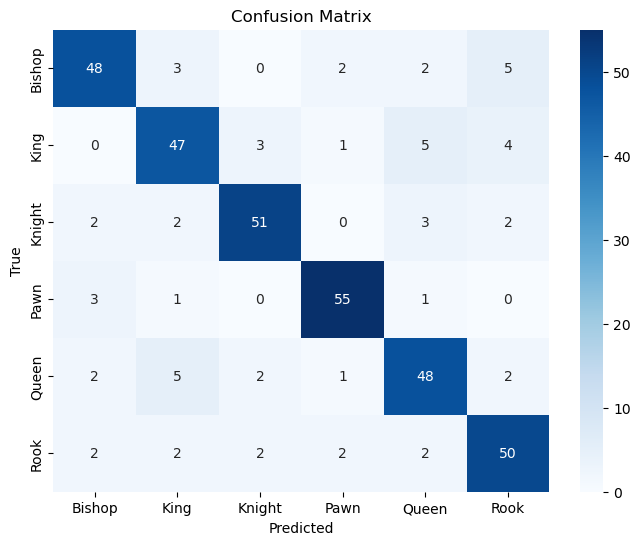

In [35]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)
class_names = test_dataset.classes
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Classification report
print(classification_report(all_labels, all_predictions, target_names=class_names))

              precision    recall  f1-score   support

      Bishop       0.84      0.80      0.82        60
        King       0.78      0.78      0.78        60
      Knight       0.88      0.85      0.86        60
        Pawn       0.90      0.92      0.91        60
       Queen       0.79      0.80      0.79        60
        Rook       0.79      0.83      0.81        60

    accuracy                           0.83       360
   macro avg       0.83      0.83      0.83       360
weighted avg       0.83      0.83      0.83       360

